# 1. Introduction

The goal of this notebook is to preprocess a large dataset of mortgage loan applications to improve its quality and ensure the accuracy of a default prediction model.
Key steps include:
1. Introduction
2. Library imports
3. Load dataset
4. Data cleaning
5. Handling missing values
6. Exploratory data analysis
7. Outliers and noise detection
8. Feature engineering
9. Save the preprocessed dataset


# 2. Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization defaults
sns.set_style('white')
sns.set_palette('Set2')

# 3. Load Dataset

In [2]:
data_path = '/Users/hoale/Code/Mortgage_Loan_Data_Preprocessing/Loan_Default.csv'
df = pd.read_csv(data_path)

# Display basic dataset information
print(f'Dataset shape: {df.shape}')
df.head()

# Quick summary
df.info()
df.describe().T

Dataset shape: (148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  U

,count,mean,std,min,25%,50%,75%,max
ID,148670.0,99224.500000,42917.476598,24890.000000,62057.25000,99224.50000,136391.750000,1.735590e+05
year,148670.0,2019.000000,0.000000,2019.000000,2019.00000,2019.00000,2019.000000,2.019000e+03
loan_amount,148670.0,331117.743997,183909.310127,16500.000000,196500.00000,296500.00000,436500.000000,3.576500e+06
rate_of_interest,112231.0,4.045476,0.561391,0.000000,3.62500,3.99000,4.375000,8.000000e+00
Interest_rate_spread,112031.0,0.441656,0.513043,-3.638000,0.07600,0.39040,0.775400,3.357000e+00
Upfront_charges,109028.0,3224.996127,3251.121510,0.000000,581.49000,2596.45000,4812.500000,6.000000e+04
term,148629.0,335.136582,58.409084,96.000000,360.00000,360.00000,360.000000,3.600000e+02
property_value,133572.0,497893.465696,359935.315562,8000.000000,268000.00000,418000.00000,628000.000000,1.650800e+07
income,139520.0,6957.338876,6496.586382,0.000000,3720.00000,5760.00000,8520.000000,5.785800e+05
Credit_Score,148670.0,699.789103,115.875857,500.000000,599.00000,699.00000,800.000000,9.000000e+02


'Status' is the target variable. From this statistic table, we can see that about 25% of the loans are defaulted.

# 4. Data Cleaning

In [3]:
# Remove year and ID
df = df.drop(['year','ID'], axis=1)

# Convert all column names to lowercase
df.columns = df.columns.str.lower()

# Removing duplicates
df = df.drop_duplicates()
print(f'Shape after removing duplicates: {df.shape}')

Shape after removing duplicates: (148670, 32)


In [4]:
# Convert categorical columns to lowercase (standardization)
obj_cols = df.select_dtypes(['object']).columns
for col in obj_cols:
    df[col] = df[col].apply(lambda x: str(x).lower() if pd.notnull(x) else x)   

In [5]:
# Display unique values for each categorical column
for col in obj_cols:
    print(col + ' ' + '-'*(30-len(col)) + ' ', df[col].unique())

loan_limit --------------------  ['cf' nan 'ncf']
gender ------------------------  ['sex not available' 'male' 'joint' 'female']
approv_in_adv -----------------  ['nopre' 'pre' nan]
loan_type ---------------------  ['type1' 'type2' 'type3']
loan_purpose ------------------  ['p1' 'p4' 'p3' 'p2' nan]
credit_worthiness -------------  ['l1' 'l2']
open_credit -------------------  ['nopc' 'opc']
business_or_commercial --------  ['nob/c' 'b/c']
neg_ammortization -------------  ['not_neg' 'neg_amm' nan]
interest_only -----------------  ['not_int' 'int_only']
lump_sum_payment --------------  ['not_lpsm' 'lpsm']
construction_type -------------  ['sb' 'mh']
occupancy_type ----------------  ['pr' 'sr' 'ir']
secured_by --------------------  ['home' 'land']
total_units -------------------  ['1u' '2u' '3u' '4u']
credit_type -------------------  ['exp' 'equi' 'crif' 'cib']
co-applicant_credit_type ------  ['cib' 'exp']
age ---------------------------  ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<2

In [6]:
# Convert object variable to category
for col in obj_cols:
    df[col] = df[col].astype('category')

# 5. Handling Missing Values

In [7]:
df.replace({'gender': {'sex not available': np.nan}}, inplace=True)

/var/folders/b9/_pzwgqx90zl_0smjhfdfr33r0000gn/T/ipykernel_94345/3089754653.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.replace({'gender': {'sex not available': np.nan}}, inplace=True)


In [8]:
# Check missing values percentage
missing_percent = df.isnull().mean() * 100
print('Missing Values Percentage:\n', missing_percent[missing_percent > 0].sort_values(ascending=False), sep='')

Missing Values Percentage:
upfront_charges              26.664425
gender                       25.330598
interest_rate_spread         24.644515
rate_of_interest             24.509989
dtir1                        16.224524
property_value               10.155378
ltv                          10.155378
income                        6.154571
loan_limit                    2.249277
approv_in_adv                 0.610749
age                           0.134526
submission_of_application     0.134526
loan_purpose                  0.090133
neg_ammortization             0.081388
term                          0.027578
dtype: float64


Missing values percentage ranges from 0.02% to 26.66%. Since it will be a waste to drop any of these columns, we will instead impute them with appropriate values.

In [9]:
ratio_cols = ['dtir1', 'ltv']
num_cols = df.select_dtypes(['float64','int64']).columns.drop(ratio_cols)

# Impute numerical columns with median (except for dtir1 and ltv)
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0])

In [10]:
# Check missing values percentage
missing_percent = df.isnull().mean() * 100
print('Missing Values Percentage:\n', missing_percent[missing_percent > 0].sort_values(ascending=False), sep='')

Missing Values Percentage:
dtir1    16.224524
ltv      10.155378
dtype: float64


# 6. Exploratory Data Analysis (EDA)

## 6.1 Target variable

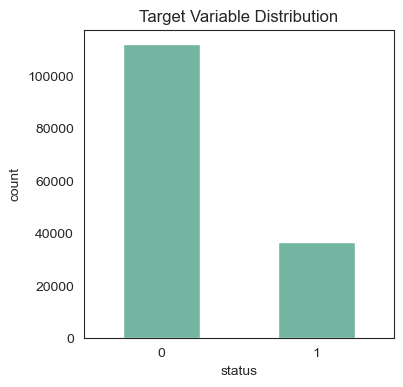

In [11]:
# Distribution of target variable
plt.figure(figsize=(4, 4))
sns.countplot(x='status', data=df, width=0.5)
plt.title('Target Variable Distribution')
plt.show()

___

## 6.2 Categorical variables

Some features have significant imbalance distribution among its values which is not meaningful in making predictionss. Therefore, we will **remove** those features of which one value appears in **more than 97%** of records.


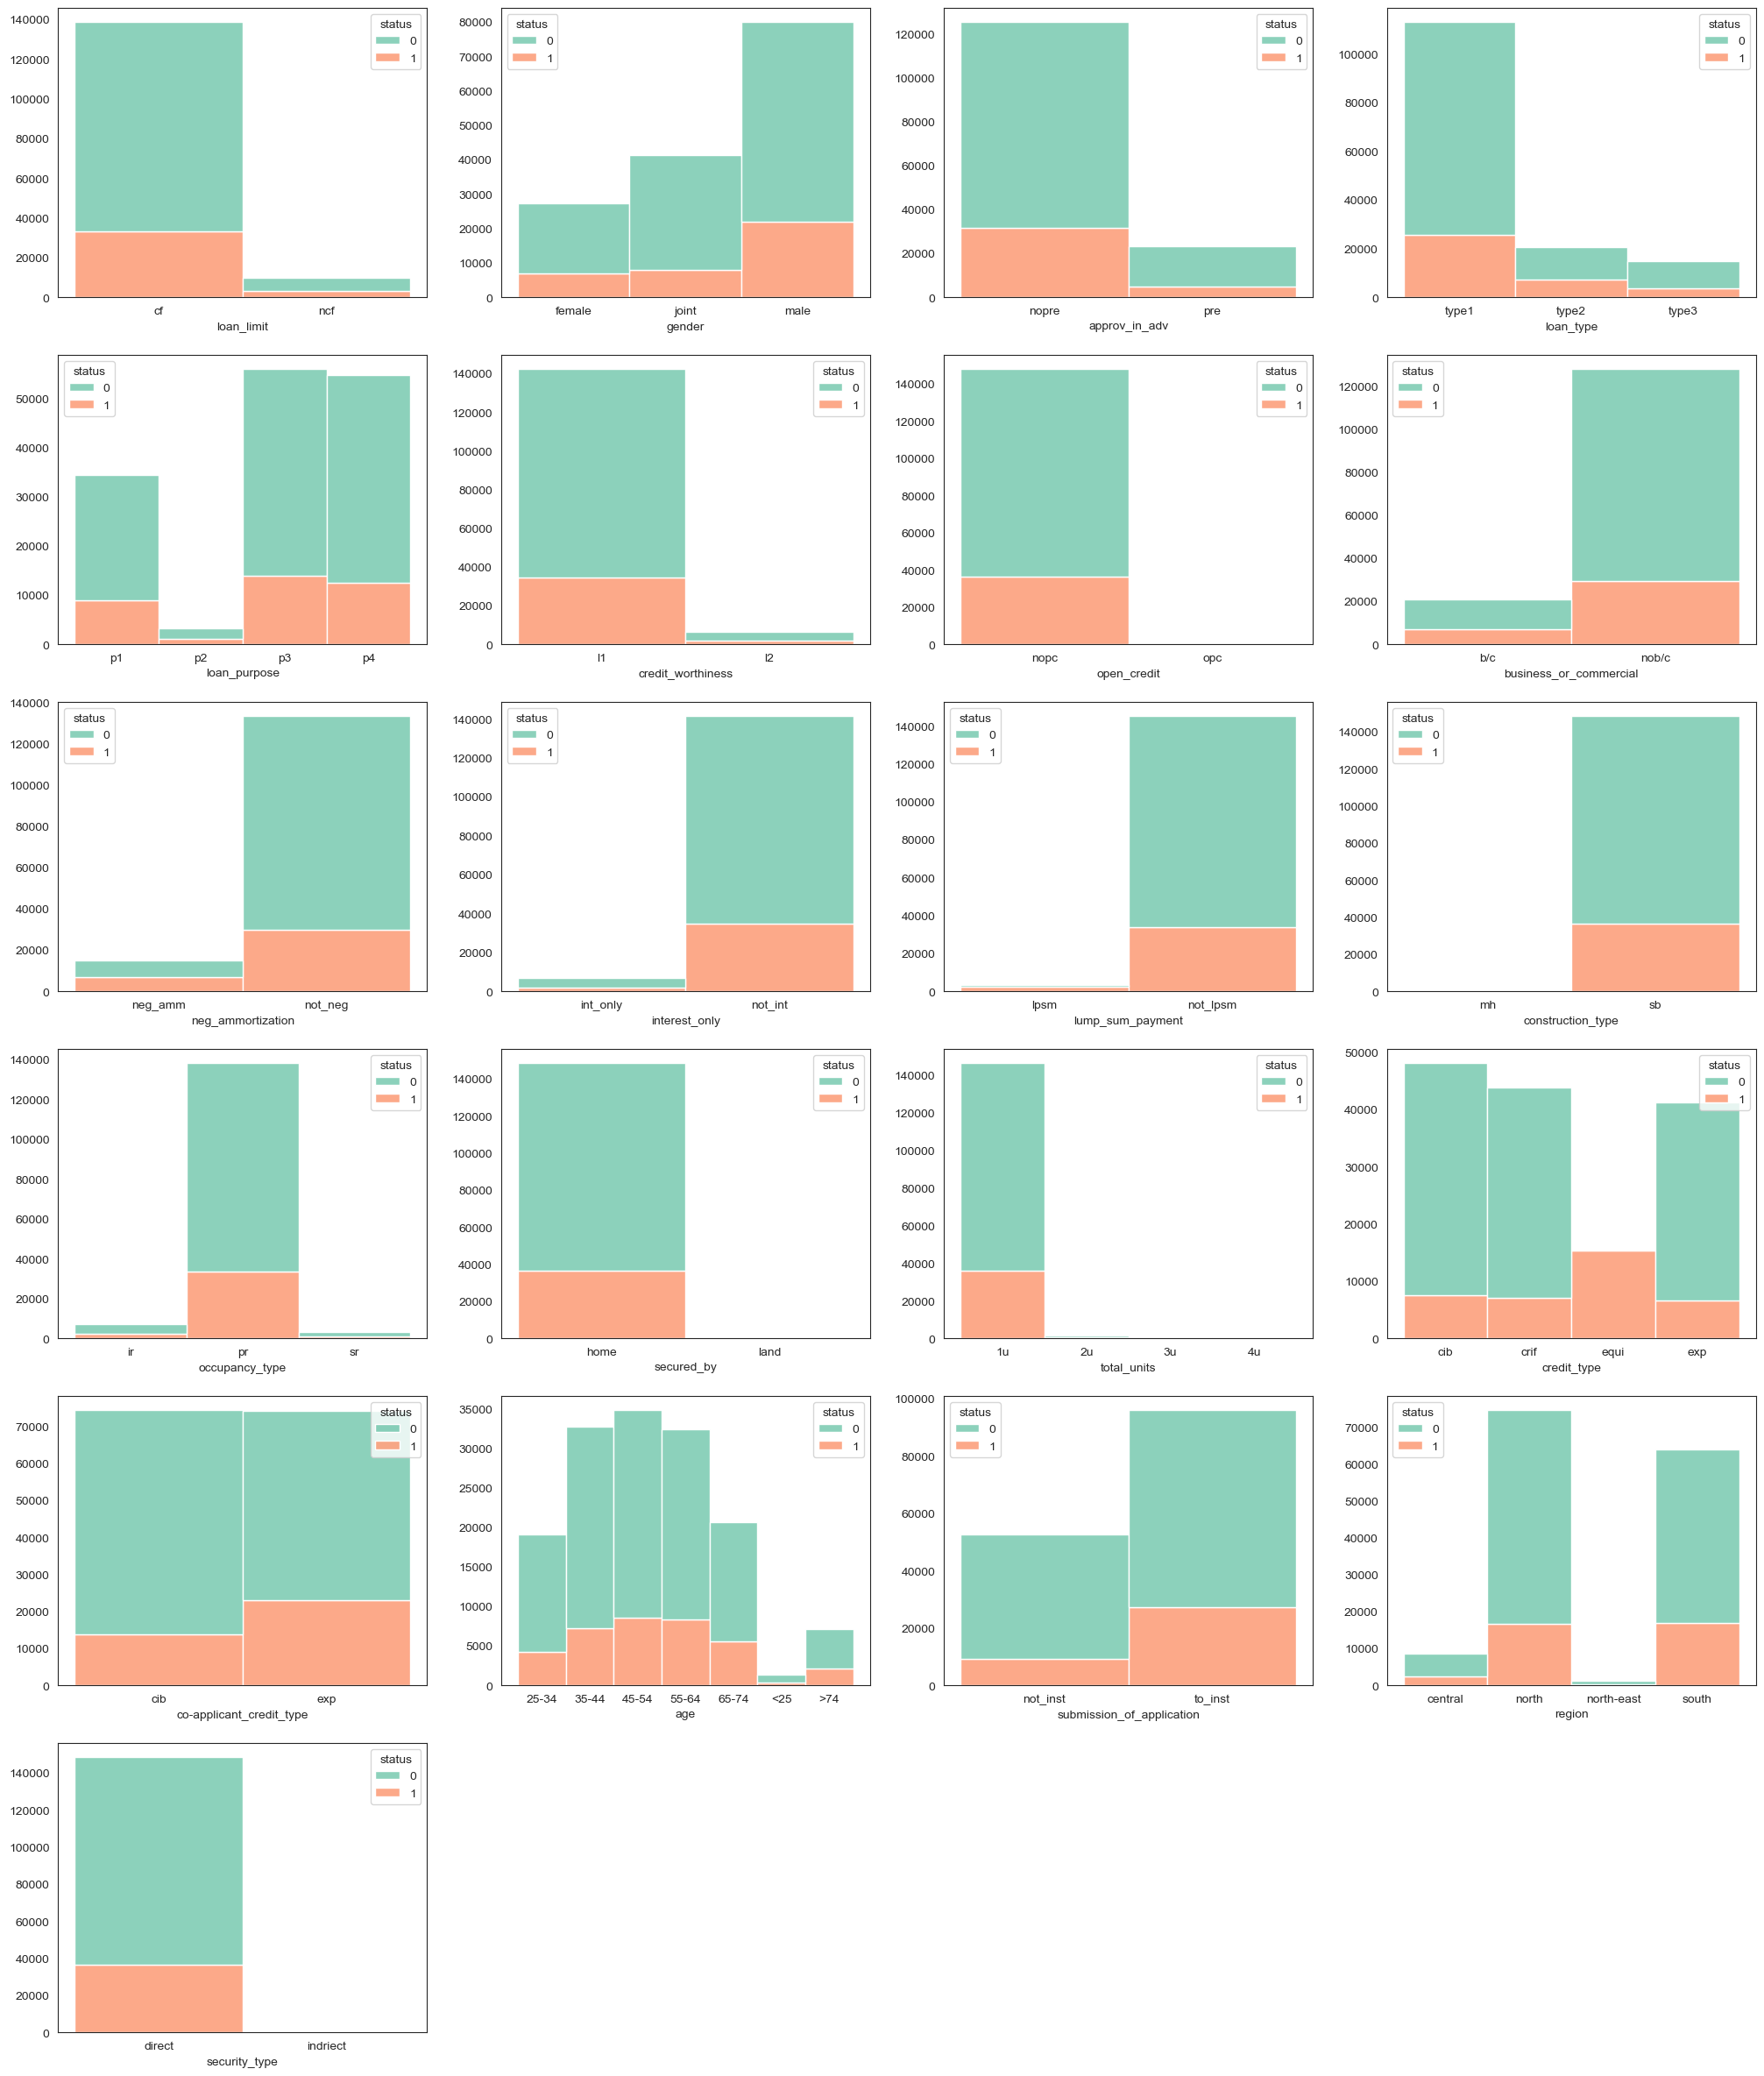

In [12]:
f1 = plt.figure(figsize=(25,30))
for col in obj_cols:
    i = obj_cols.to_list().index(col) + 1
    ax = f1.add_subplot(6,4,i)
    g1 = sns.histplot(df, x=df[col], legend=True, hue='status', multiple='stack')
    g1.set(ylabel=None)
plt.show()

In [13]:
threshold = 0.97
for col in obj_cols:
    if max(df[col].value_counts()/len(df)) > threshold:
        df = df.drop(col, axis=1)
        obj_cols = obj_cols.drop(col)
        print(f'{col} has been removed')

open_credit has been removed
lump_sum_payment has been removed
construction_type has been removed
secured_by has been removed
total_units has been removed
security_type has been removed


___

## 6.3 Numerical variables

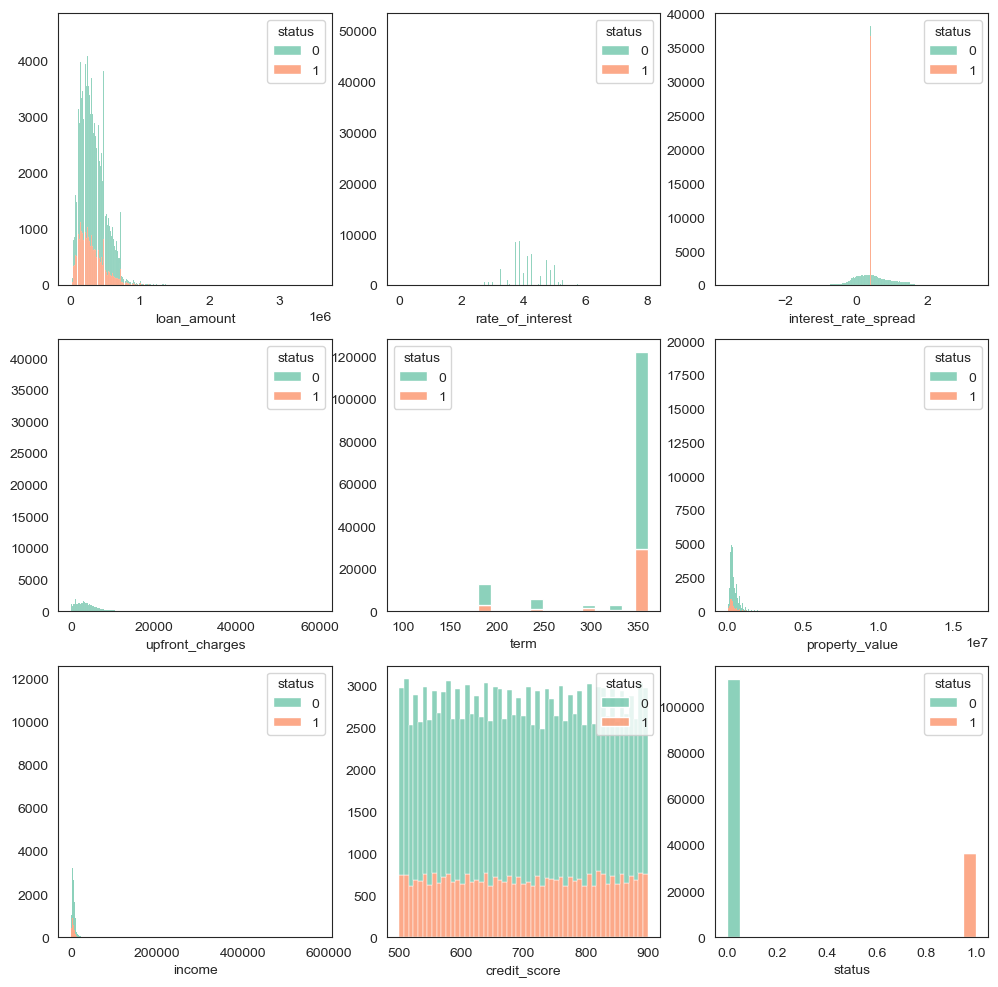

In [14]:
f1 = plt.figure(figsize=(12,12))
for col in num_cols:
    i = num_cols.to_list().index(col) + 1
    ax = f1.add_subplot(3,3,i)
    g1 = sns.histplot(df, x=df[col], legend=True, hue='status', multiple='stack')
    g1.set(ylabel=None)
plt.show()

- Credit_score can be **removed** because the ratio between default and non-defaut loans remain unchanged at all levels.
- There are outliers in each of these features except for term, which we will investigate further.


In [15]:
df = df.drop('credit_score', axis=1)
num_cols = num_cols.drop('credit_score')

# 7. Outlier and Noise Detection

## 7.1 Loan amount

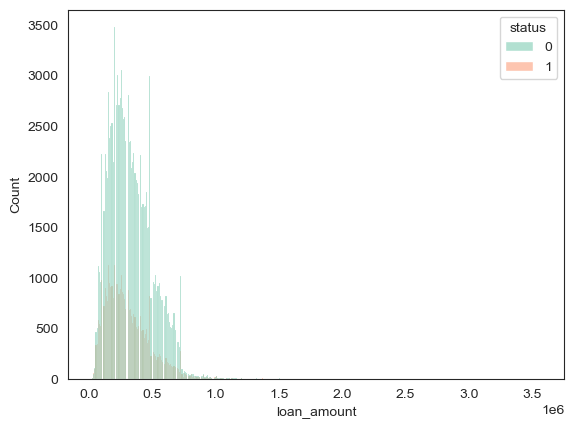

In [16]:
sns.histplot(df, x=df['loan_amount'], legend=True, hue='status',)
plt.show()

In [17]:
df.loan_amount.sort_values(ascending=False)

4321      3576500
98146     3346500
86408     3006500
3762      3006500
54519     3006500
           ...   
89973       26500
113985      26500
135325      16500
136556      16500
124860      16500
Name: loan_amount, Length: 148670, dtype: int64

A value of 6500 has been added to each record. We will deduct 6500 from each record.

In [18]:
df['loan_amount'] = df['loan_amount']-6500

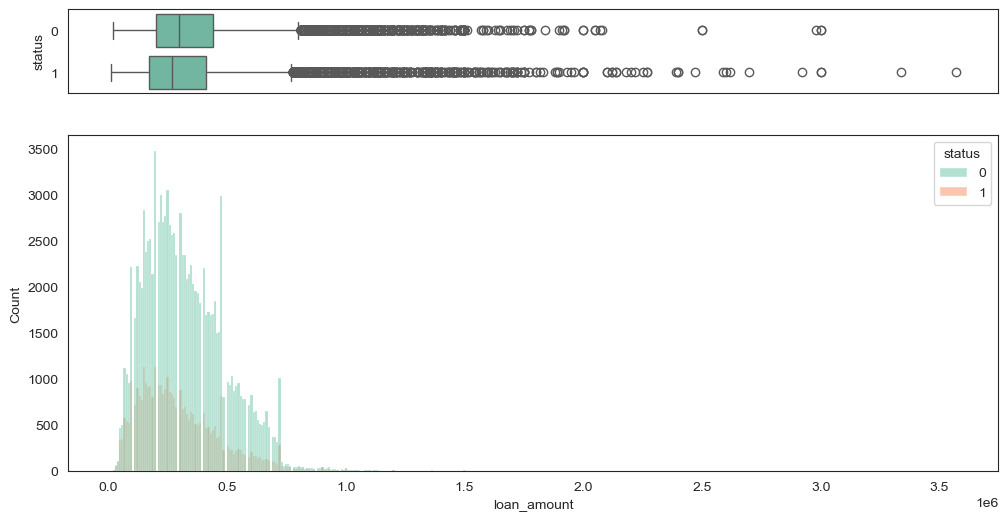

In [19]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(12,6))
 
# assigning a graph to each ax
sns.boxplot(df, x='loan_amount', y='status', orient='h', ax=ax_box)
sns.histplot(df, x='loan_amount', hue='status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

---

## 7.2 Property value

In [20]:
df['property_value'].sort_values(ascending=False)

17114     16508000.0
99460     12008000.0
42558     11008000.0
100371    10008000.0
124997     9268000.0
             ...    
65238         8000.0
46287         8000.0
47807         8000.0
123343        8000.0
55286         8000.0
Name: property_value, Length: 148670, dtype: float64

It seems that each record has been increased by 8000.

In [21]:
df['property_value'] = df['property_value']-8000

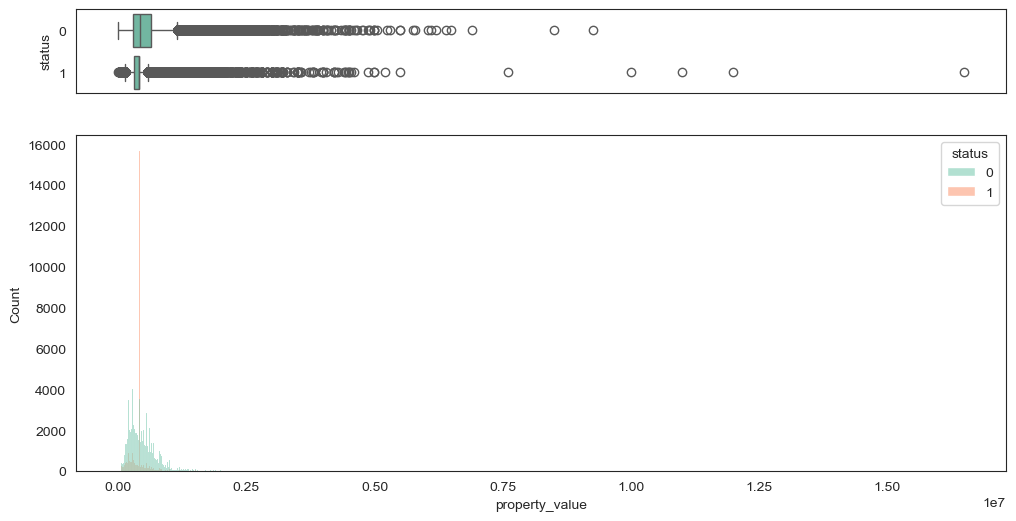

In [22]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(12,6))
 
# assigning a graph to each ax
sns.boxplot(df, x='property_value', y='status', orient='h', ax=ax_box)
sns.histplot(df, x='property_value', hue='status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [23]:
df['property_value'].value_counts()

property_value
410000.0     16930
300000.0      2792
250000.0      2763
350000.0      2679
400000.0      2537
             ...  
4640000.0        1
3870000.0        1
5750000.0        1
2610000.0        1
2690000.0        1
Name: count, Length: 385, dtype: int64

The number of loans that have property_value = 410,000 is extremely high. The majority of these loans are defaulted. This might affect the model accuracy if these records are indeed artificial noise. 

Theoretically, banks should not lend if LTV is over 1. We can use a dataset after **removing records with property_value = 410,000 and LTV > 1** for next steps.

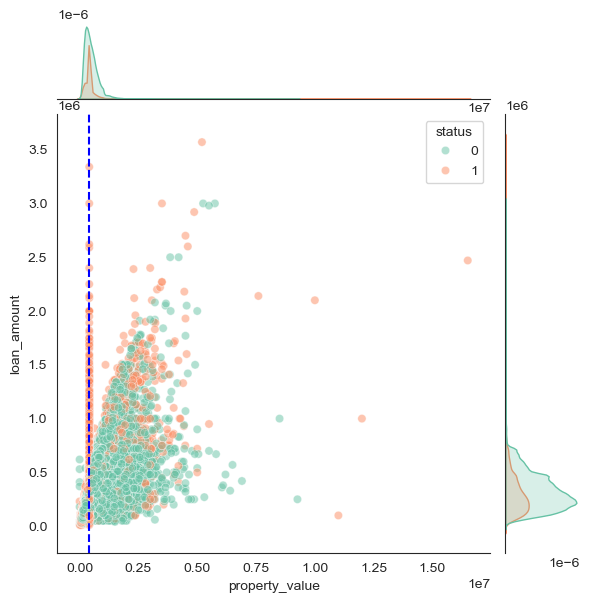

In [24]:
sns.jointplot(data=df, x='property_value', y='loan_amount', hue='status', alpha=0.5)
plt.axvline(x=410000, color='blue', linestyle='--')
plt.show()

In [25]:
pv_outlier = df[(df['property_value']== 410000) & (df['loan_amount']/df['property_value']>1)]
df1 = df.drop(pv_outlier.index)

### Property value & Loan amount before and after removing outliers

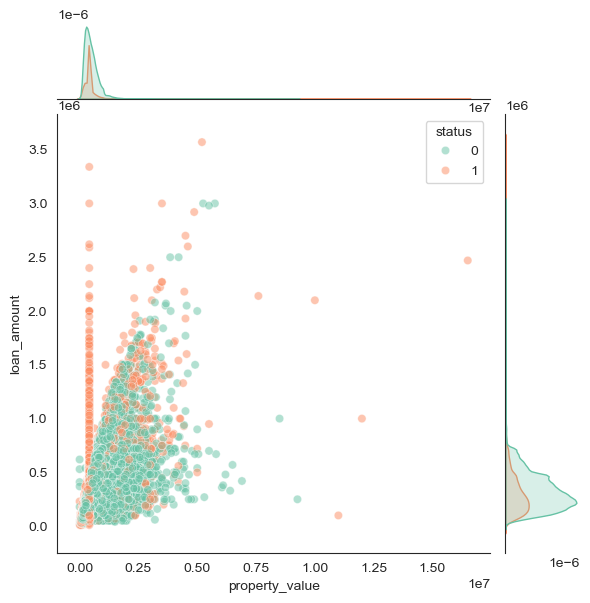

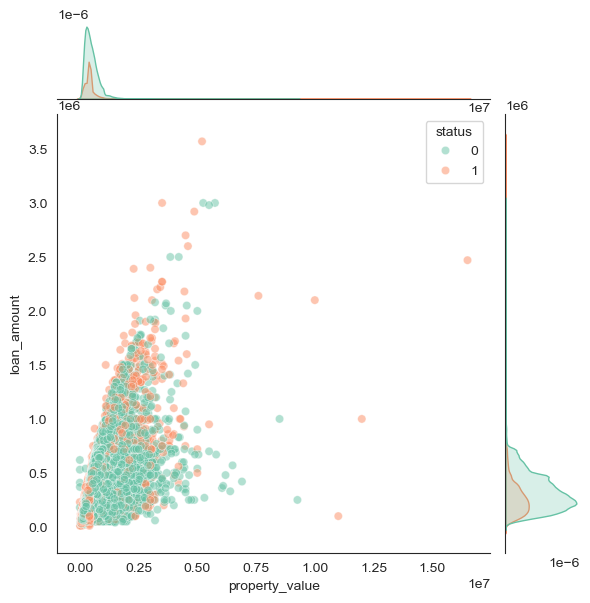

In [26]:
sns.jointplot(data=df, x='property_value', y='loan_amount', hue='status', alpha=0.5, height=6)
sns.jointplot(data=df1, x='property_value', y='loan_amount', hue='status', alpha=0.5, height=6)
plt.show()

___

## 7.3 Income

In [27]:
df1['income'].value_counts(ascending=False)

income
5760.0     10054
3600.0      1241
4200.0      1233
4800.0      1174
3120.0      1166
           ...  
51300.0        1
53940.0        1
52200.0        1
47700.0        1
79920.0        1
Name: count, Length: 970, dtype: int64

In [28]:
df1['income'].sort_values(ascending=False)

62237     578580.0
33621     377220.0
65351     374400.0
46142     335880.0
60996     335880.0
            ...   
136681         0.0
62810          0.0
90314          0.0
143847         0.0
63817          0.0
Name: income, Length: 144649, dtype: float64

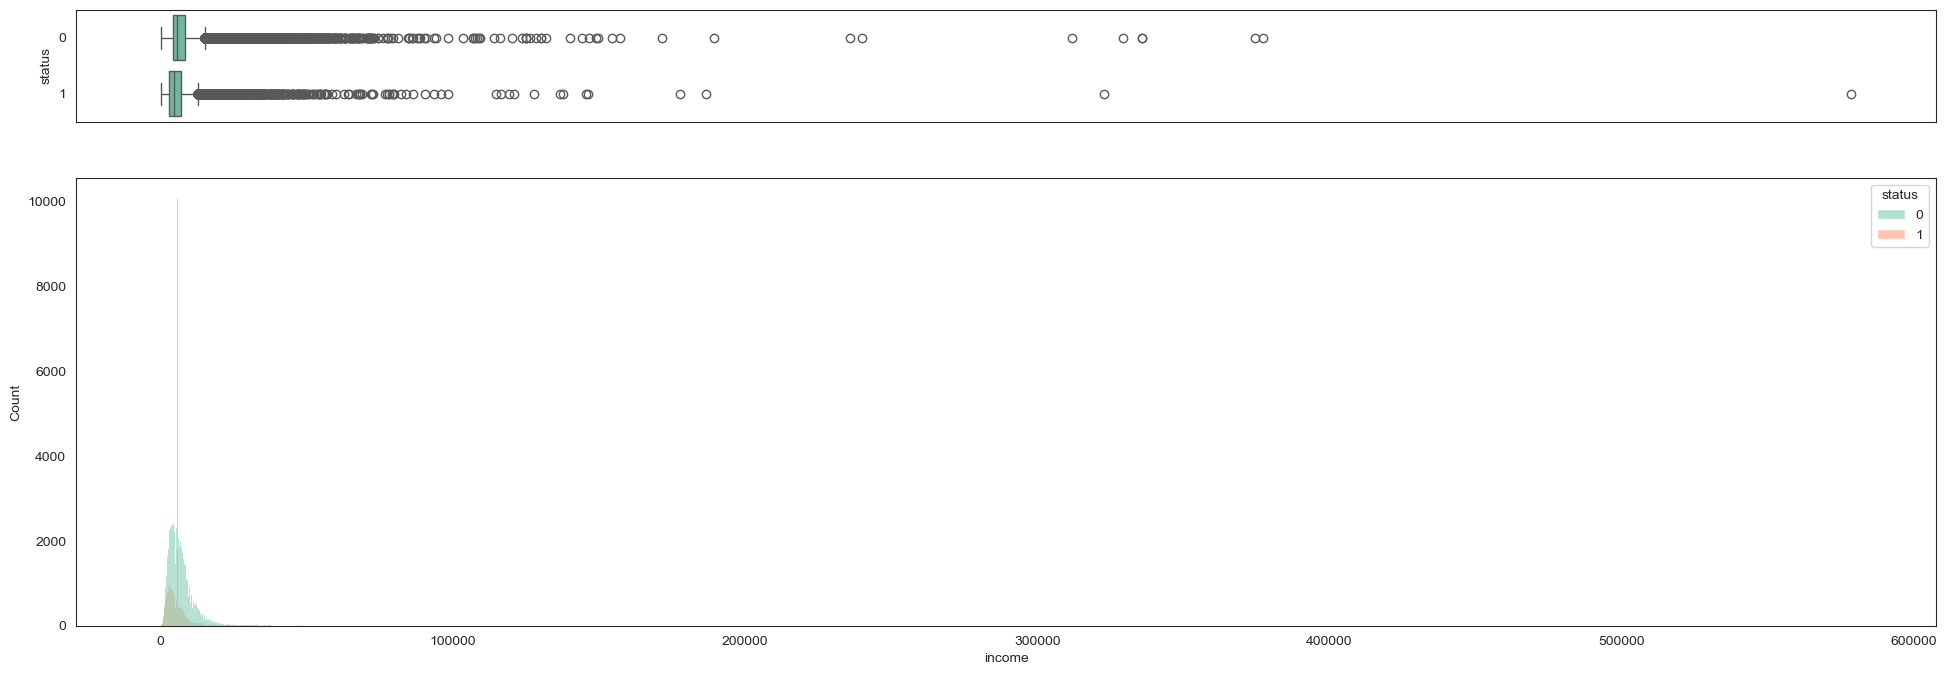

In [29]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(24,8))
 
# assigning a graph to each ax
sns.boxplot(df1, x='income', y='status', orient='h', ax=ax_box)
sns.histplot(df1, x='income', hue='status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

It is extremely unusual that the value *income = 5,760* appears more than 10,000 instances while any other value only appear less than 3,000 times.

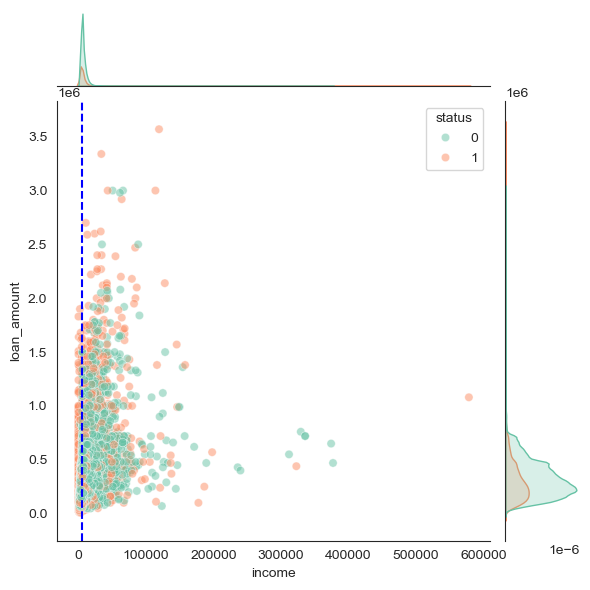

In [30]:
sns.jointplot(data=df, x='income', y='loan_amount', hue='status', alpha=0.5)
plt.axvline(x=5760, color='blue', linestyle='--')
plt.show()

In [31]:
income_outlier = df1[(df1['income']==5760) & (df1['loan_amount']/df1['income']>1)]
df2 = df1.drop(income_outlier.index, axis=0)

### Income after removing outliers

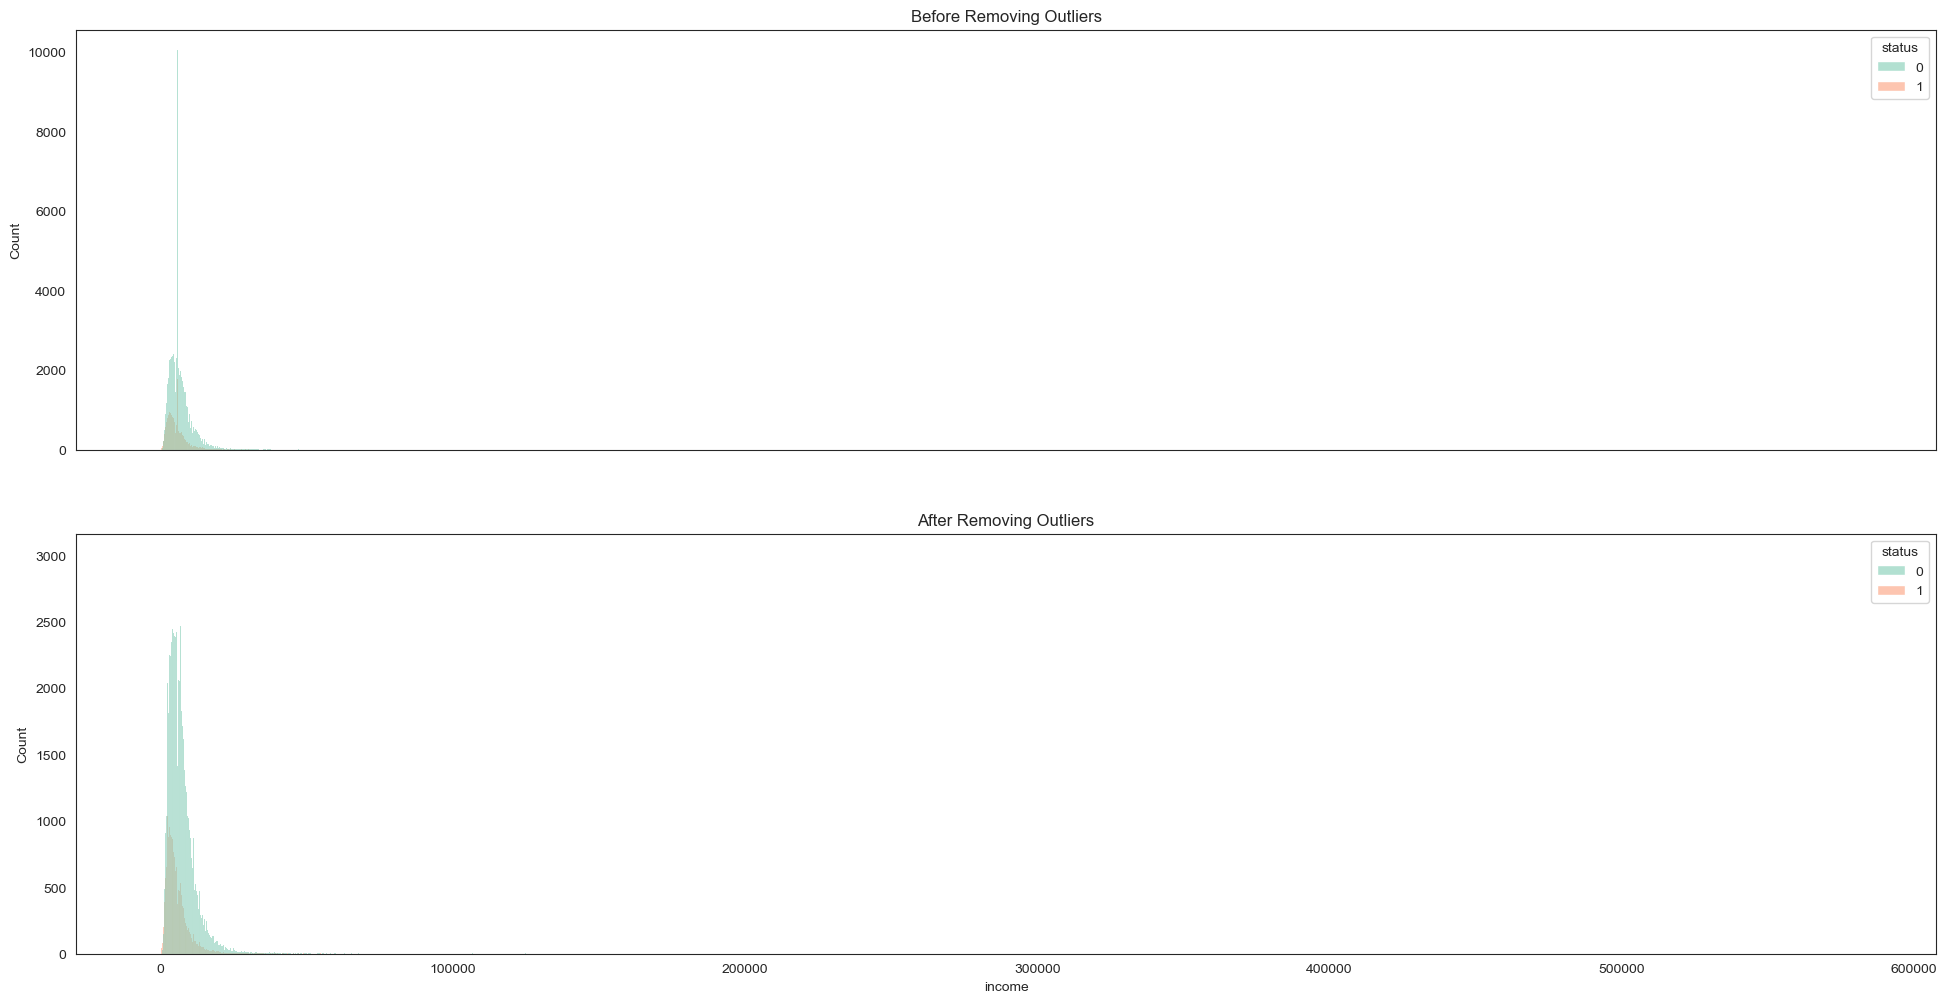

In [32]:
f, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(24,12))
 
# assigning a graph to each ax
sns.histplot(df1, x='income', hue='status', ax=ax1)
sns.histplot(df2, x='income', hue='status', ax=ax2)
 
# Remove x axis name for the boxplot
ax1.set(title='Before Removing Outliers')
ax2.set(title='After Removing Outliers')
plt.show()

___

## 7.4 Loan-to-Value and Debt-to-Income

We have removed outliers in Loan amount, Property value and Income. We are now ready to recalcuate LTV adn DTIR.

In [33]:
df2['ltv'] = df2['loan_amount']/df2['property_value']
df2['dtir1'] = df2['loan_amount']/df2['income']

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134595 entries, 0 to 148669
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 134595 non-null  category
 1   gender                     134595 non-null  category
 2   approv_in_adv              134595 non-null  category
 3   loan_type                  134595 non-null  category
 4   loan_purpose               134595 non-null  category
 5   credit_worthiness          134595 non-null  category
 6   business_or_commercial     134595 non-null  category
 7   loan_amount                134595 non-null  int64   
 8   rate_of_interest           134595 non-null  float64 
 9   interest_rate_spread       134595 non-null  float64 
 10  upfront_charges            134595 non-null  float64 
 11  term                       134595 non-null  float64 
 12  neg_ammortization          134595 non-null  category
 13  interest_only      

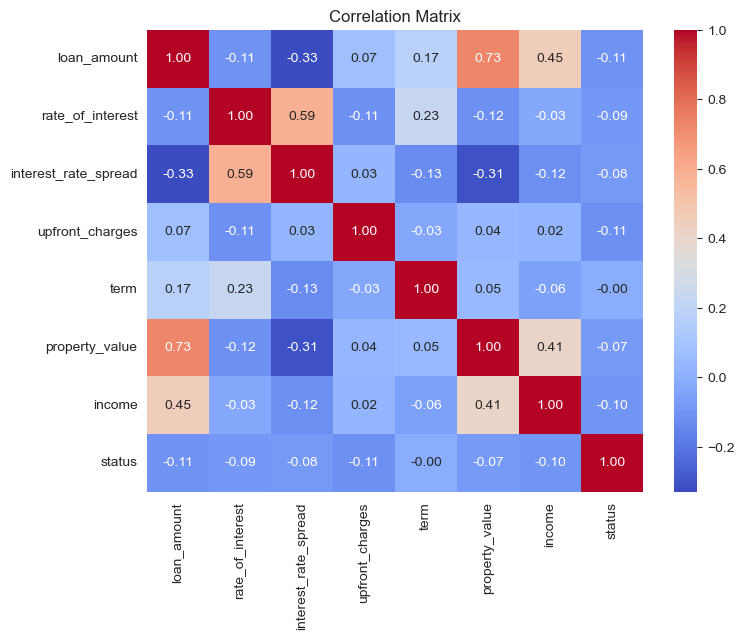

In [35]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df2[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 8. Feature Engineering (to be continued)

In [36]:
# Log-transform skewed numerical features
from scipy.stats import skew

skewed_features = df2[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.75].index

for col in high_skew:
    df2[col] = np.log1p(df2[col])

# One-hot encode categorical variables
df2 = pd.get_dummies(df2, columns=obj_cols, drop_first=True)

# 9. Save the Preprocessed Dataset

In [37]:
# Save the preprocessed dataset
df2.to_csv('preprocessed_dataset.csv', index=False)